In [1]:
1 + (10, 10, 10)

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from utils import *

In [2]:
data2d = np.load('./data/2d/floor1.npy')
data2d, min, max = minmax(data2d, axis=0)
print(data2d.shape)
data1d = pd.read_csv('./data/1d/floor1.csv').drop(['Date', 'sum'], axis=1).to_numpy()
data1d, min, max = minmax(data1d, axis=0)
print(data1d.shape)

(13176, 12, 20)
(13176, 4)


In [3]:
X2d, Y2d = make_sequence(data2d)
X1d, Y1d = make_sequence(data1d)

In [4]:
train_size = int(len(X2d) * .6)
eval_size = int(len(X2d) * .2)

In [5]:
train_X = X2d[:train_size]
val_X = X2d[train_size:train_size+eval_size]
test_X = X2d[train_size+eval_size:]

train_Y = Y1d[:train_size]
val_Y = Y1d[train_size:train_size+eval_size]
test_Y = Y1d[train_size+eval_size:]

In [6]:
train_set = CustomDataset(train_X, train_Y)
val_set = CustomDataset(val_X, val_Y)
test_set = CustomDataset(test_X, test_Y)

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True, shuffle=False)

In [7]:
print(f'train: {train_X.shape[0]}')

print(f'val: {val_X.shape[0]}')

print(f'test: {test_X.shape[0]}')

train: 7704
val: 2568
test: 2569


In [8]:
xx, yy = next(iter(train_loader))
print(xx.shape)

torch.Size([64, 168, 12, 20])


In [9]:
import time
from tqdm import tqdm
from model import STModel
from config import STConfig
from torch import nn
from torch.optim import AdamW

epochs = 50
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STModel(in_shape=xx.shape[1:], s_hid=32, t_hid=512, n_section=4)
model = model.to(device)
opt = AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()

train_losses = []
val_losses = []
for epoch in range(epochs):
    t0 = time.time()
    tr_loss = 0.0
    model.train()
    for X, Y in tqdm(train_loader):
        opt.zero_grad()
        X, Y = X.to(device), Y.to(device)
        preds = model(X)
        loss = 10*criterion(preds, Y) + criterion2(preds, Y)
        loss.backward()
        opt.step()
        tr_loss += loss.item()/len(train_loader)
    train_losses.append(tr_loss)
    t1 = time.time()
    print(f'Epoch {epoch+1} | Train: {tr_loss:.6f} | {t1-t0:.2f}sec')

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        for X, Y in tqdm(val_loader):
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss = criterion(preds, Y)
            val_loss += loss.item()/len(val_loader)

        val_losses.append(val_loss)
        print(f'Epoch {epoch+1} | Val: {val_loss:.6f} | {time.time()-t1:.2f}sec')

100%|██████████| 121/121 [00:10<00:00, 11.03it/s]


Epoch 1 | Train: 0.670065 | 10.97sec


100%|██████████| 41/41 [00:01<00:00, 38.22it/s]


Epoch 1 | Val: 0.053204 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.17it/s]


Epoch 2 | Train: 0.438855 | 9.19sec


100%|██████████| 41/41 [00:01<00:00, 38.56it/s]


Epoch 2 | Val: 0.026903 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.21it/s]


Epoch 3 | Train: 0.359832 | 9.16sec


100%|██████████| 41/41 [00:01<00:00, 39.42it/s]


Epoch 3 | Val: 0.026775 | 1.04sec


100%|██████████| 121/121 [00:08<00:00, 13.73it/s]


Epoch 4 | Train: 0.355651 | 8.81sec


100%|██████████| 41/41 [00:01<00:00, 37.76it/s]


Epoch 4 | Val: 0.026584 | 1.09sec


100%|██████████| 121/121 [00:09<00:00, 12.93it/s]


Epoch 5 | Train: 0.334767 | 9.36sec


100%|██████████| 41/41 [00:01<00:00, 39.19it/s]


Epoch 5 | Val: 0.021677 | 1.06sec


100%|██████████| 121/121 [00:08<00:00, 13.63it/s]


Epoch 6 | Train: 0.251341 | 8.88sec


100%|██████████| 41/41 [00:01<00:00, 40.57it/s]


Epoch 6 | Val: 0.018077 | 1.01sec


100%|██████████| 121/121 [00:09<00:00, 13.30it/s]


Epoch 7 | Train: 0.233964 | 9.11sec


100%|██████████| 41/41 [00:01<00:00, 38.65it/s]


Epoch 7 | Val: 0.017438 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.16it/s]


Epoch 8 | Train: 0.229581 | 9.20sec


100%|██████████| 41/41 [00:01<00:00, 37.73it/s]


Epoch 8 | Val: 0.017369 | 1.09sec


100%|██████████| 121/121 [00:09<00:00, 12.75it/s]


Epoch 9 | Train: 0.225808 | 9.49sec


100%|██████████| 41/41 [00:01<00:00, 36.93it/s]


Epoch 9 | Val: 0.016928 | 1.11sec


100%|██████████| 121/121 [00:09<00:00, 12.75it/s]


Epoch 10 | Train: 0.220015 | 9.50sec


100%|██████████| 41/41 [00:01<00:00, 36.85it/s]


Epoch 10 | Val: 0.016211 | 1.11sec


100%|██████████| 121/121 [00:09<00:00, 12.67it/s]


Epoch 11 | Train: 0.211353 | 9.56sec


100%|██████████| 41/41 [00:01<00:00, 37.07it/s]


Epoch 11 | Val: 0.015706 | 1.11sec


100%|██████████| 121/121 [00:09<00:00, 12.73it/s]


Epoch 12 | Train: 0.198696 | 9.51sec


100%|██████████| 41/41 [00:01<00:00, 36.76it/s]


Epoch 12 | Val: 0.014515 | 1.12sec


100%|██████████| 121/121 [00:09<00:00, 12.72it/s]


Epoch 13 | Train: 0.184240 | 9.52sec


100%|██████████| 41/41 [00:01<00:00, 36.71it/s]


Epoch 13 | Val: 0.013911 | 1.12sec


100%|██████████| 121/121 [00:09<00:00, 12.76it/s]


Epoch 14 | Train: 0.179278 | 9.52sec


100%|██████████| 41/41 [00:01<00:00, 37.12it/s]


Epoch 14 | Val: 0.013829 | 1.10sec


100%|██████████| 121/121 [00:09<00:00, 12.59it/s]


Epoch 15 | Train: 0.177106 | 9.61sec


100%|██████████| 41/41 [00:01<00:00, 37.48it/s]


Epoch 15 | Val: 0.013620 | 1.11sec


100%|██████████| 121/121 [00:09<00:00, 12.71it/s]


Epoch 16 | Train: 0.175543 | 9.52sec


100%|██████████| 41/41 [00:01<00:00, 38.35it/s]


Epoch 16 | Val: 0.013686 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.14it/s]


Epoch 17 | Train: 0.174398 | 9.21sec


100%|██████████| 41/41 [00:01<00:00, 37.59it/s]


Epoch 17 | Val: 0.013471 | 1.09sec


100%|██████████| 121/121 [00:09<00:00, 13.23it/s]


Epoch 18 | Train: 0.173226 | 9.14sec


100%|██████████| 41/41 [00:01<00:00, 38.16it/s]


Epoch 18 | Val: 0.013493 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.13it/s]


Epoch 19 | Train: 0.172326 | 9.21sec


100%|██████████| 41/41 [00:01<00:00, 38.95it/s]


Epoch 19 | Val: 0.013598 | 1.05sec


100%|██████████| 121/121 [00:09<00:00, 13.23it/s]


Epoch 20 | Train: 0.171614 | 9.15sec


100%|██████████| 41/41 [00:01<00:00, 38.43it/s]


Epoch 20 | Val: 0.013540 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.25it/s]


Epoch 21 | Train: 0.170936 | 9.13sec


100%|██████████| 41/41 [00:01<00:00, 38.76it/s]


Epoch 21 | Val: 0.013393 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.14it/s]


Epoch 22 | Train: 0.170474 | 9.21sec


100%|██████████| 41/41 [00:01<00:00, 38.16it/s]


Epoch 22 | Val: 0.013369 | 1.08sec


100%|██████████| 121/121 [00:09<00:00, 13.19it/s]


Epoch 23 | Train: 0.169791 | 9.17sec


100%|██████████| 41/41 [00:01<00:00, 39.20it/s]


Epoch 23 | Val: 0.013367 | 1.05sec


100%|██████████| 121/121 [00:09<00:00, 13.21it/s]


Epoch 24 | Train: 0.168967 | 9.16sec


100%|██████████| 41/41 [00:01<00:00, 38.75it/s]


Epoch 24 | Val: 0.013389 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.23it/s]


Epoch 25 | Train: 0.168404 | 9.14sec


100%|██████████| 41/41 [00:01<00:00, 38.62it/s]


Epoch 25 | Val: 0.013229 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.31it/s]


Epoch 26 | Train: 0.167790 | 9.09sec


100%|██████████| 41/41 [00:01<00:00, 38.16it/s]


Epoch 26 | Val: 0.013286 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.32it/s]


Epoch 27 | Train: 0.166975 | 9.08sec


100%|██████████| 41/41 [00:01<00:00, 38.27it/s]


Epoch 27 | Val: 0.013231 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.30it/s]


Epoch 28 | Train: 0.166144 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 38.58it/s]


Epoch 28 | Val: 0.013133 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.28it/s]


Epoch 29 | Train: 0.164981 | 9.11sec


100%|██████████| 41/41 [00:01<00:00, 38.70it/s]


Epoch 29 | Val: 0.013050 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.30it/s]


Epoch 30 | Train: 0.163631 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 38.72it/s]


Epoch 30 | Val: 0.013059 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.32it/s]


Epoch 31 | Train: 0.162951 | 9.08sec


100%|██████████| 41/41 [00:01<00:00, 38.79it/s]


Epoch 31 | Val: 0.012988 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.29it/s]


Epoch 32 | Train: 0.162108 | 9.11sec


100%|██████████| 41/41 [00:01<00:00, 38.21it/s]


Epoch 32 | Val: 0.012887 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.07it/s]


Epoch 33 | Train: 0.161526 | 9.26sec


100%|██████████| 41/41 [00:01<00:00, 38.02it/s]


Epoch 33 | Val: 0.012976 | 1.08sec


100%|██████████| 121/121 [00:09<00:00, 13.12it/s]


Epoch 34 | Train: 0.161042 | 9.22sec


100%|██████████| 41/41 [00:01<00:00, 38.03it/s]


Epoch 34 | Val: 0.012890 | 1.08sec


100%|██████████| 121/121 [00:09<00:00, 13.22it/s]


Epoch 35 | Train: 0.160655 | 9.15sec


100%|██████████| 41/41 [00:01<00:00, 37.98it/s]


Epoch 35 | Val: 0.012932 | 1.08sec


100%|██████████| 121/121 [00:09<00:00, 13.21it/s]


Epoch 36 | Train: 0.160336 | 9.16sec


100%|██████████| 41/41 [00:01<00:00, 39.03it/s]


Epoch 36 | Val: 0.013050 | 1.05sec


100%|██████████| 121/121 [00:08<00:00, 13.64it/s]


Epoch 37 | Train: 0.159982 | 8.87sec


100%|██████████| 41/41 [00:01<00:00, 39.64it/s]


Epoch 37 | Val: 0.012966 | 1.03sec


100%|██████████| 121/121 [00:09<00:00, 13.33it/s]


Epoch 38 | Train: 0.159730 | 9.08sec


100%|██████████| 41/41 [00:01<00:00, 35.93it/s]


Epoch 38 | Val: 0.012941 | 1.14sec


100%|██████████| 121/121 [00:09<00:00, 12.65it/s]


Epoch 39 | Train: 0.159465 | 9.57sec


100%|██████████| 41/41 [00:03<00:00, 11.94it/s]


Epoch 39 | Val: 0.012909 | 3.43sec


100%|██████████| 121/121 [00:26<00:00,  4.55it/s]


Epoch 40 | Train: 0.159196 | 26.62sec


100%|██████████| 41/41 [00:03<00:00, 11.27it/s]


Epoch 40 | Val: 0.013003 | 3.64sec


100%|██████████| 121/121 [00:09<00:00, 12.76it/s]


Epoch 41 | Train: 0.158928 | 9.49sec


100%|██████████| 41/41 [00:01<00:00, 38.59it/s]


Epoch 41 | Val: 0.012992 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.21it/s]


Epoch 42 | Train: 0.158528 | 9.17sec


100%|██████████| 41/41 [00:01<00:00, 38.21it/s]


Epoch 42 | Val: 0.013006 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.30it/s]


Epoch 43 | Train: 0.158332 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 38.70it/s]


Epoch 43 | Val: 0.012911 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.28it/s]


Epoch 44 | Train: 0.158012 | 9.11sec


100%|██████████| 41/41 [00:01<00:00, 38.50it/s]


Epoch 44 | Val: 0.012907 | 1.07sec


100%|██████████| 121/121 [00:09<00:00, 13.31it/s]


Epoch 45 | Train: 0.157654 | 9.09sec


100%|██████████| 41/41 [00:01<00:00, 39.10it/s]


Epoch 45 | Val: 0.012952 | 1.05sec


100%|██████████| 121/121 [00:09<00:00, 13.31it/s]


Epoch 46 | Train: 0.157363 | 9.11sec


100%|██████████| 41/41 [00:01<00:00, 39.01it/s]


Epoch 46 | Val: 0.012879 | 1.05sec


100%|██████████| 121/121 [00:09<00:00, 13.29it/s]


Epoch 47 | Train: 0.157154 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 39.27it/s]


Epoch 47 | Val: 0.012953 | 1.04sec


100%|██████████| 121/121 [00:09<00:00, 13.30it/s]


Epoch 48 | Train: 0.156939 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 38.93it/s]


Epoch 48 | Val: 0.012999 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.31it/s]


Epoch 49 | Train: 0.156649 | 9.09sec


100%|██████████| 41/41 [00:01<00:00, 38.77it/s]


Epoch 49 | Val: 0.012935 | 1.06sec


100%|██████████| 121/121 [00:09<00:00, 13.31it/s]


Epoch 50 | Train: 0.156491 | 9.10sec


100%|██████████| 41/41 [00:01<00:00, 38.45it/s]

Epoch 50 | Val: 0.012927 | 1.07sec


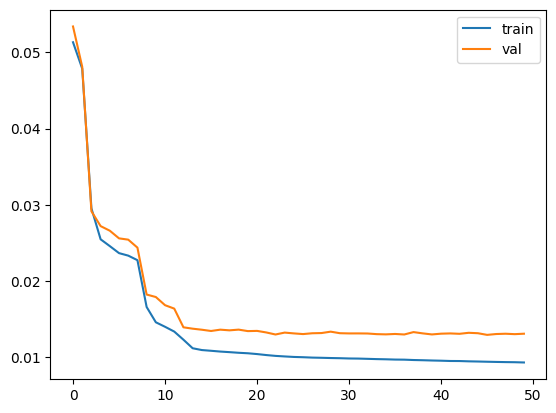

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

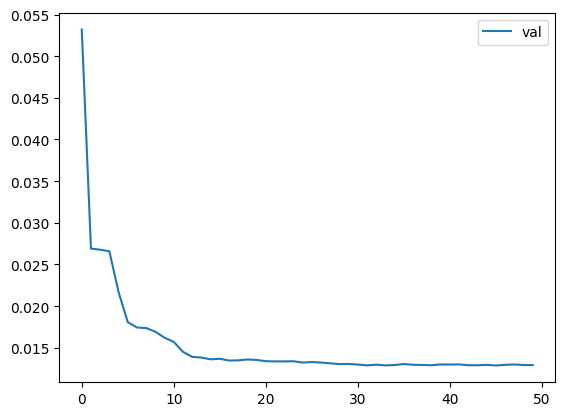

In [11]:
import matplotlib.pyplot as plt

# plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [16]:
with torch.no_grad():
    model.eval()
    mse, mae, rmse, mape, smape = 0, 0, 0, 0, 0
    for X, Y in tqdm(test_loader):
        X = X.to(device)
        Y = Y.detach().cpu().numpy()

        preds = model(X)
        preds = preds.detach().cpu().numpy()
        mse += MSE(preds, Y, axis=(0, 1))/len(test_loader)
        mae += MAE(preds, Y, axis=(0, 1))/len(test_loader)
        rmse += MSE(preds, Y, axis=(0, 1), root=True)/len(test_loader)
        mape += MAPE(preds, Y, axis=(0, 1))/len(test_loader)
        smape += SMAPE(preds, Y, axis=(0, 1))/len(test_loader)

    print(f'MSE: {mse.mean():.4f}')
    print(f'MAE: {mae.mean():.4f}')
    print(f'RMSE: {rmse.mean():.4f}')
    print(f'MAPE: {mape.mean():.4f}')
    print(f'SMAPE: {smape.mean():.4f}')

100%|██████████| 41/41 [00:01<00:00, 27.54it/s]

MSE: 0.0068
MAE: 0.0541
RMSE: 0.0755
MAPE: 4.5465
SMAPE: 2.4458


In [12]:
# l1l2 loss
with torch.no_grad():
    model.eval()
    mse, mae, rmse, mape, smape = 0, 0, 0, 0, 0
    for X, Y in tqdm(test_loader):
        X = X.to(device)
        Y = Y.detach().cpu().numpy()

        preds = model(X)
        preds = preds.detach().cpu().numpy()
        mse += MSE(preds, Y, axis=(0, 1))/len(test_loader)
        mae += MAE(preds, Y, axis=(0, 1))/len(test_loader)
        rmse += MSE(preds, Y, axis=(0, 1), root=True)/len(test_loader)
        mape += MAPE(preds, Y, axis=(0, 1))/len(test_loader)
        smape += SMAPE(preds, Y, axis=(0, 1))/len(test_loader)

    print(f'MSE: {mse.mean():.4f}')
    print(f'MAE: {mae.mean():.4f}')
    print(f'RMSE: {rmse.mean():.4f}')
    print(f'MAPE: {mape.mean():.4f}')
    print(f'SMAPE: {smape.mean():.4f}')

100%|██████████| 41/41 [00:01<00:00, 27.67it/s]

MSE: 0.0068
MAE: 0.0536
RMSE: 0.0757
MAPE: 4.4955
SMAPE: 2.4212


# Best Model 가져오기!